#### Tutorial 5 - Coalition vs. Opposition Dynamics

This tutorial pulls together the skills and methods we developed in the previous tutorials - analyzing **topic distributions and sentiment** - and applies them to a new focus: **party alignment**. By comparing **coalition and opposition** behaviors, we not only deepen our understanding of a single parliament (like we did in **Tutorial 2, Section 3.4**), but also scale the analysis across multiple countries. This demonstrates the **transferability of our workflow** and allows us to uncover patterns that are **robust across different parliamentary systems**. 

What we will do:
1) Compute **mean sentiment** by country and CAP category separately for coalition and opposition parties, visualize with heatmaps and examine cross-country patterns using cosine distance and dendrograms.
2) Compute **topic shares** (proportion of words per CAP category) for coalition and opposition parties, visualize them with heatmaps and explore cross-country patterns using cosine distance and dendrograms.
3) Analyze **relative word count differences** between coalition and opposition to see which parliaments or CAP categories are dominated by each party type.

With this approach, we aim to answer **possible research questions**, such as:
- *Do Coalitions and Oppositions across parliaments agree on what's important?*
- *Do Coalitions and Oppositions across parliaments express similar tones on the same topic?*



**1. Setup & Data Loading**

This setup (installing/importing) libraries and data loading & filtering steps are the **same as in Tutorial 1**. For detailed explanations, see **Tutorial 1, Sections 1-2**.

In [ ]:
# Uncomment and run the following line if you haven't installed pandas yet
# !pip install ipywidgets

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
import numpy as np
import csv
import scipy.cluster.hierarchy as sch
from sklearn.metrics.pairwise import cosine_distances


In [3]:
# Set consistent style
sns.set_theme(style="whitegrid", font_scale=1.2)

In [4]:
# ---- 1. First, we have to increase the CSV field size limit ----
max_int = 2**31 - 1
while True:
    try:
        csv.field_size_limit(max_int)
        break
    except OverflowError:
        max_int = max_int // 10

countries = ["AT", "BA", "BE", "BG", "CZ", "DK", "EE", "ES", "ES-CT", "ES-GA", "ES-PV", 
             "FR", "GB", "GR", "HR", "HU", "IS", "IT", "LV", 
             "NL", "NO", "PL", "PT", "RS", "SE", "SI", "TR", "UA"] #change country codes according to your available datasets

base_dir = Path().resolve()

# ---- 2. Choose what columns to read (including CAP and sentiment columns) ----
cols_to_keep = [
    "id", "date", "lang_code", "lang", "speaker_role", "speaker_MP",
    "speaker_minister", "speaker_party", "speaker_party_name", "party_status",
    "party_orientation", "speaker_id", "speaker_name", "speaker_gender",
    "speaker_birth", "word_count", "CAP_category", "sent3_category", "sent6_category", "sent_logit"
]

# ---- 3. Define dtypes to reduce memory ----
dtypes = {
    "id": str,
    "date": str,
    "lang_code": "category",
    "lang": "category",
    "speaker_role": "category",
    "speaker_MP": "category",
    "speaker_minister": "category",
    "speaker_party": "category",
    "speaker_party_name": "category",
    "party_status": "category",
    "party_orientation": "category",
    "speaker_id": "category",
    "speaker_name": "category",
    "speaker_gender": "category",
    "speaker_birth": "Int32",
    "word_count": "Int32",
    "CAP_category": "category",
    "sent3_category": "category",
    "sent6_category": "category",
    "sent_logit": "float32"
}

# ---- 4. Create lists to accumulate filtered chunks ----
all_chunks = []

for country in countries:
    file_path = base_dir / f"ParlaMint-{country}_processed_no_text.tsv"

    # --- 4.1. Read in chunks using pandas.read_csv ----
    for chunk in pd.read_csv(file_path, sep="\t", usecols=cols_to_keep,
                             dtype=dtypes, chunksize=50_000, engine="python"):
        chunk["country"] = country
        chunk["country"] = chunk["country"].astype("category")

        # ---- 4.2. Filter MPs with regular role ----
        filtered_chunk = chunk.query("speaker_MP == 'MP' and speaker_role == 'Regular'")

        # ---- 4.3. Drop rows where CAP_category or sentiment is empty ----
        filtered_chunk = filtered_chunk[
            filtered_chunk["CAP_category"].notna() & (filtered_chunk["CAP_category"] != "") &
            filtered_chunk["sent3_category"].notna() & (filtered_chunk["sent3_category"] != "") &
            filtered_chunk["sent6_category"].notna() & (filtered_chunk["sent6_category"] != "")
        ]

        # ---- 4.4. Accumulate filtered chunks ----
        if not filtered_chunk.empty:
            all_chunks.append(filtered_chunk)

# ---- 5. Concatenate all accumulated chunks into DataFrames ----
filtered_all = pd.concat(all_chunks, ignore_index=True)
del all_chunks
print("All filtered:", filtered_all.shape)

All filtered: (4225608, 21)


In [5]:
filtered_all["CAP_category"] = filtered_all["CAP_category"].astype("category")
filtered_all = filtered_all[~filtered_all["CAP_category"].isin(["Mix", "Other"])]
filtered_all["CAP_category"] = filtered_all["CAP_category"].cat.remove_unused_categories()

**2. Check for missing data**

For some countries, the dataset might not include annotated speeches from opposition. In these cases, we cannot look at the sentiment scores for the opposition and we cannot compare their tone to the coalition parties. This should be kept in mind when interpreting the heatmaps and summary statistics, since the absence of coalition/opposition data may bias cross-country comparisons.

With the help of the code below, you can easily test which countries have no annotated opposition speeches. 

In [6]:
# Find countries where opposition sentiment is completely missing
missing_opposition = opposition_sentiment[opposition_sentiment.isna().all(axis=1)].index.tolist()

print("Countries without annotated opposition data:")
print(missing_opposition)

NameError: name 'opposition_sentiment' is not defined

**3. Mean sentiment across CAP categories filtered by party status**

In **Tutorial 2, Section 3.4**, we first explored how sentiment varies across CAP categories when filtered by party status. There, we focused on a single country. Here, we extend that analysis to **all countries together**, using tools from previous tutorials, such as heatmaps, cosine distances and dendrograms, to uncover broader structural patterns in European parliamentary speech. 

Our main interest in this section is in comparing the **tone of coalition and opposition parties** when they address the same policy areas. To do this, we compute the mean sentiment scores for each country and CAP category, both overall and separately for coalition and opposition parties. We then summarize these scores with descriptive statistics (with an option to export them to TSV for further research) and visualize them using heatmaps (as in Tutorial 2). 

By looking across countries, we can test the hypothesis from **Tutorial 2, Section 3.4**, that governments tend to frame issues in a more positive light, while opposition parties adopt a more critical or negative tone across policy debates.

C:\Users\isabe\AppData\Local\Temp\ipykernel_18056\600037700.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['country', 'CAP_category'])['sent_logit']
C:\Users\isabe\AppData\Local\Temp\ipykernel_18056\600037700.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['country', 'CAP_category'])['sent_logit']
C:\Users\isabe\AppData\Local\Temp\ipykernel_18056\600037700.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

MEAN SENTIMENT SUMMARY ACROSS ALL COUNTRIES

Overall (All Parties) Mean Sentiment:
Mean: 2.073
Std: 0.282
Min: 1.096
Max: 3.188

Coalition Mean Sentiment:
Mean: 2.453
Std: 0.308
Min: 1.318
Max: 3.438

Opposition Mean Sentiment:
Mean: 1.518
Std: 0.672
Min: 0.000
Max: 2.660

DETAILED MEAN SENTIMENT BY COUNTRY
   country  overall_mean  coalition_mean  opposition_mean  difference  \
0       AT         2.193           2.658            1.697       0.961   
1       BA         2.090           2.111            2.087       0.024   
2       BE         1.949           2.254            1.783       0.470   
3       BG         2.172           2.522            1.911       0.611   
4       CZ         2.090           2.461            1.858       0.603   
5       DK         2.050           2.427            1.837       0.590   
6       EE         1.795           2.033            0.000       2.033   
7       ES         1.959           2.514            1.693       0.821   
8    ES-CT         2.005          

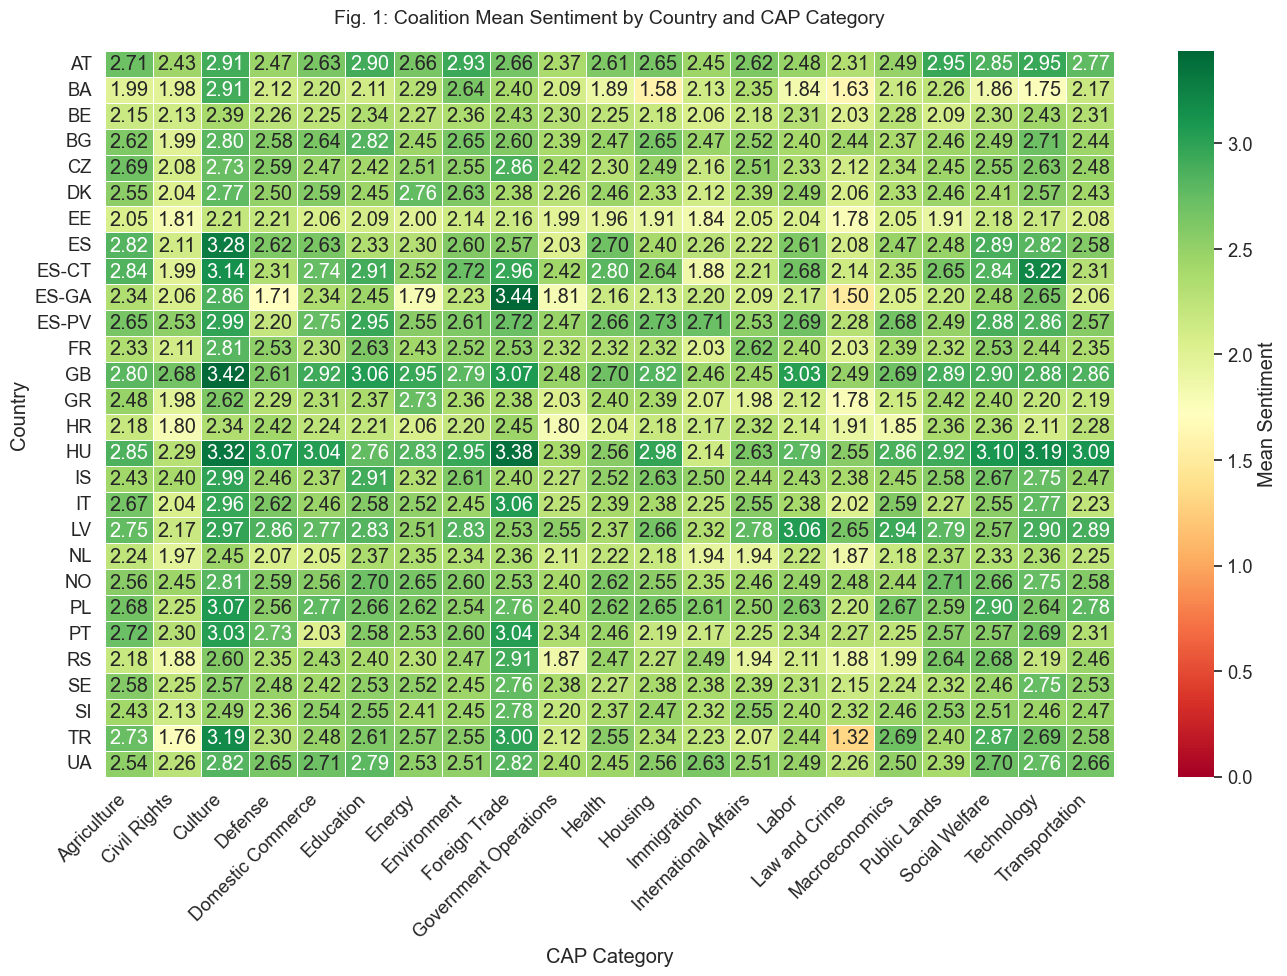

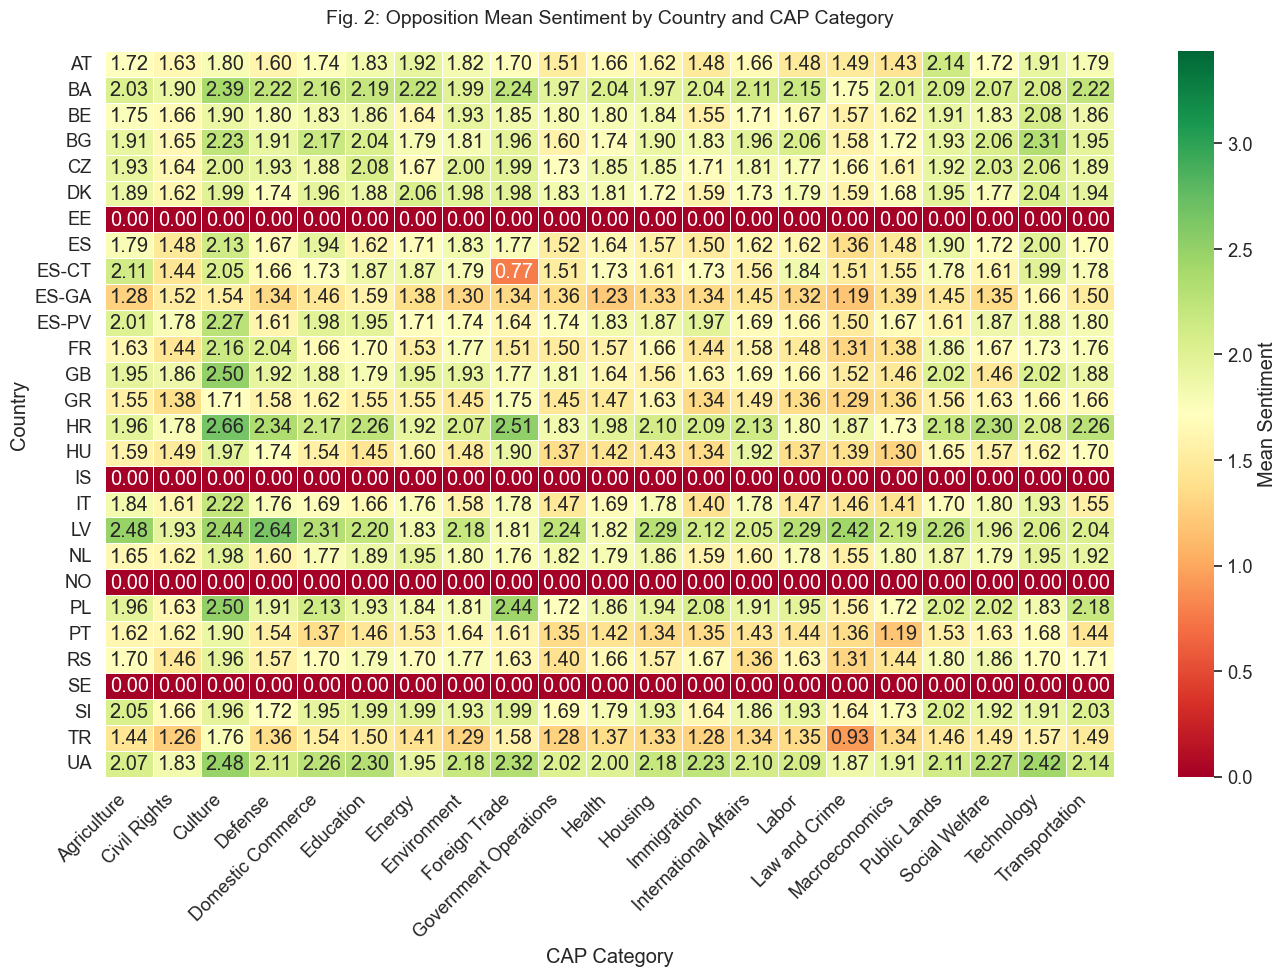


COALITION SENTIMENT DATA TABLE
CAP_category  Agriculture  Civil Rights  Culture  Defense  Domestic Commerce  \
country                                                                        
AT                  2.709         2.432    2.913    2.469              2.633   
BA                  1.993         1.975    2.911    2.116              2.200   
BE                  2.153         2.134    2.395    2.257              2.248   
BG                  2.617         1.995    2.795    2.585              2.640   
CZ                  2.687         2.084    2.733    2.589              2.470   
DK                  2.547         2.037    2.774    2.502              2.586   
EE                  2.052         1.808    2.213    2.207              2.059   
ES                  2.822         2.114    3.279    2.615              2.632   
ES-CT               2.843         1.991    3.137    2.311              2.740   
ES-GA               2.336         2.063    2.860    1.710              2.342   
ES-PV   

In [ ]:
# ---- 1. Compute mean sentiment by country and CAP category ----

# Overall (both parties combined)
overall_sentiment = (
    filtered_all
    .groupby(['country', 'CAP_category'])['sent_logit']
    .mean()
    .unstack()  # Do NOT fill with 0 here
)

# Coalition
coalition_sentiment = (
    filtered_all[filtered_all['party_status'] == 'Coalition']
    .groupby(['country', 'CAP_category'])['sent_logit']
    .mean()
    .unstack()
)

# Opposition
opposition_sentiment = (
    filtered_all[filtered_all['party_status'] == 'Opposition']
    .groupby(['country', 'CAP_category'])['sent_logit']
    .mean()
    .unstack()
)

# ---- 1.1 Reindex coalition and opposition to include all countries ----
all_countries = overall_sentiment.index
coalition_sentiment = coalition_sentiment.reindex(all_countries)
opposition_sentiment = opposition_sentiment.reindex(all_countries)

# ---- 1.2 Optional: Fill missing CAP categories with 0 for existing countries ----
coalition_sentiment = coalition_sentiment.fillna(0)
opposition_sentiment = opposition_sentiment.fillna(0)

# ---- 2. Print summary statistics ----
def print_stats(df, name):
    values = df.values
    print(f"\n{name} Mean Sentiment:")
    print(f"Mean: {pd.Series(values.flatten()).mean():.3f}")
    print(f"Std: {pd.Series(values.flatten()).std():.3f}")
    print(f"Min: {pd.Series(values.flatten()).min():.3f}")
    print(f"Max: {pd.Series(values.flatten()).max():.3f}")

print("MEAN SENTIMENT SUMMARY ACROSS ALL COUNTRIES")
print("=" * 50)

print_stats(overall_sentiment, "Overall (All Parties)")
print_stats(coalition_sentiment, "Coalition")
print_stats(opposition_sentiment, "Opposition")

# ---- 3. Create detailed mean sentiment by country ----
country_stats = []
for country in overall_sentiment.index:
    overall_mean = overall_sentiment.loc[country].mean()
    coalition_mean = coalition_sentiment.loc[country].mean()
    opposition_mean = (
        opposition_sentiment.loc[country].mean()
        if not opposition_sentiment.loc[country].isna().all()
        else float('nan')
    )
    difference = (
        coalition_mean - opposition_mean
        if not pd.isna(opposition_mean)
        else float('nan')
    )

    missing_opposition = opposition_sentiment.loc[country].isna().all()

    country_stats.append({
        'country': country,
        'overall_mean': overall_mean,
        'coalition_mean': coalition_mean,
        'opposition_mean': opposition_mean,
        'difference': difference,
        'opposition_missing': missing_opposition
    })

country_stats_df = pd.DataFrame(country_stats)
print("\n" + "="*50)
print("DETAILED MEAN SENTIMENT BY COUNTRY")
print("="*50)
print(country_stats_df.round(3))

# ---- 3.1 Save as TSV ----
output_path = "detailed_mean_sentiment_by_country.tsv"
country_stats_df.to_csv(output_path, sep='\t', index=False)
print(f"\nSaved detailed sentiment table to {output_path}")

# ---- 4. Determine shared color scale ----
# Stack ignores column headers; dropna ensures missing values are ignored
all_values = pd.concat([coalition_sentiment.stack(), opposition_sentiment.stack()]).dropna()
vmin = all_values.min()
vmax = all_values.max()

# ---- 4.1. Heatmap for Coalition sentiment ----
plt.figure(figsize=(14, 10))
sns.heatmap(
    coalition_sentiment,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    vmin=vmin,
    vmax=vmax,
    cbar_kws={'label': 'Mean Sentiment'},
    linewidths=0.5,
    linecolor='white'
)
plt.title("Fig. 1a: Coalition Mean Sentiment by Country and CAP Category", fontsize=14, pad=20)
plt.xlabel("CAP Category")
plt.ylabel("Country")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

4# ---- 4.2. Heatmap for Opposition sentiment ----
plt.figure(figsize=(14, 10))
sns.heatmap(
    opposition_sentiment, #remove void opposition? TODO
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    vmin=vmin,
    vmax=vmax,
    cbar_kws={'label': 'Mean Sentiment'},
    linewidths=0.5,
    linecolor='white'
)
plt.title("Fig. 1b, Opposition Mean Sentiment by Country and CAP Category", fontsize=14, pad=20)
plt.xlabel("CAP Category")
plt.ylabel("Country")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ---- 5. Print actual data tables ----
print("\n" + "="*50)
print("COALITION SENTIMENT DATA TABLE")
print("="*50)
print(coalition_sentiment.round(3))

print("\n" + "="*50)
print("OPPOSITION SENTIMENT DATA TABLE")
print("="*50)
print(opposition_sentiment.round(3))

print("\n" + "="*50)
print("OVERALL SENTIMENT DATA TABLE")
print("="*50)
print(overall_sentiment.round(3))


*In the overall statistics, we see that the **mean sentiment** across all countries and categories is **2.073**. When broken down by party status, the **coalition** has a higher mean sentiment (**2.453**) while the opposition is lower (**1.518**). This difference is also visible in the heatmaps: **Fig. 1** appears generally greener than **Fig. 2**, reflecting the more positive tone of coalition speeches.*

*The coalition heatmap (Fig. 1a) allows us to identify specific CAP categories and countries with particularly positve or negative sentiment. For example, the coalition in **Latvia (LV)** and **Great Britain (GB)** shows very postive sentiment overall. However, it's important to note that this could partly result from the limited number of annotated coalition speeches in some countries - e.g., in GB there are more speeches annotated with '-' as party status than coalition and opposition.*

With the code below, you can check for a selected country how many annotated speeches we have for each 'party_status'.

*The opposition heatmap (Fig. 1b) shows a generally more negative tone. Several countries have missing opposition data, including **Estonia (EE), Iceland (IS), Norway (NO) and Sweden (SE)**. The most positive opposition sentiment is observed in **Latvia (LV)** and **Bosnia (BA)**, while the most negative occurs in **Spain-Galicia (ES-GA)** and **Turkey (TR)** which is not surprising, considering that their coalitions had negative sentiment scores as well, indicating that their parliaments discuss in a more negative tone overall.*

In [23]:
# ---- Select a country ----
selected_country = "GB"  # change to any country you want

# Filter the dataset for that country
country_data = filtered_all[filtered_all['country'] == selected_country]

# Count number of speeches per party_status
annotation_counts = country_data['party_status'].value_counts()

print(f"Annotation counts for {selected_country}:")
print(annotation_counts)

Annotation counts for GB:
party_status
-             370334
Opposition    121729
Coalition      13247
Name: count, dtype: int64


If you see that a country has **very few coalition/opposition-annotated speeches but a large number for '-', the *mean sentiment for coalition*** may not be representative and can appear artificially high or low. 

**3.1. Cosine distance of sentiment patterns by party status and CAP category**

With the help of cosine distances (see Tutorial 3, section 3 for more details), we can now **compute the similarity of sentiment patterns between parliaments**, party statuses and CAP categories. By representing each country-party combination as a vector of mean sentiment across CAP categories, the cosine distance measures the angle between these vectors, giving us a sense of relative similarity independent of absolute sentiment scores. 

This method allows us to:
- Identify countries whose coalition or opposition parties express simiar sentiment patterns.
- Detect outlier countries with unusually positive or negative tones in specific policy areas.
- Compare coalition vs. opposition patterns acorss coutnries to see if certain CAP categories consistently trigger more positive or negative sentiment depending on party status.

The resulting heatmap and dendrogram provide a nice visual overview of these relationships.

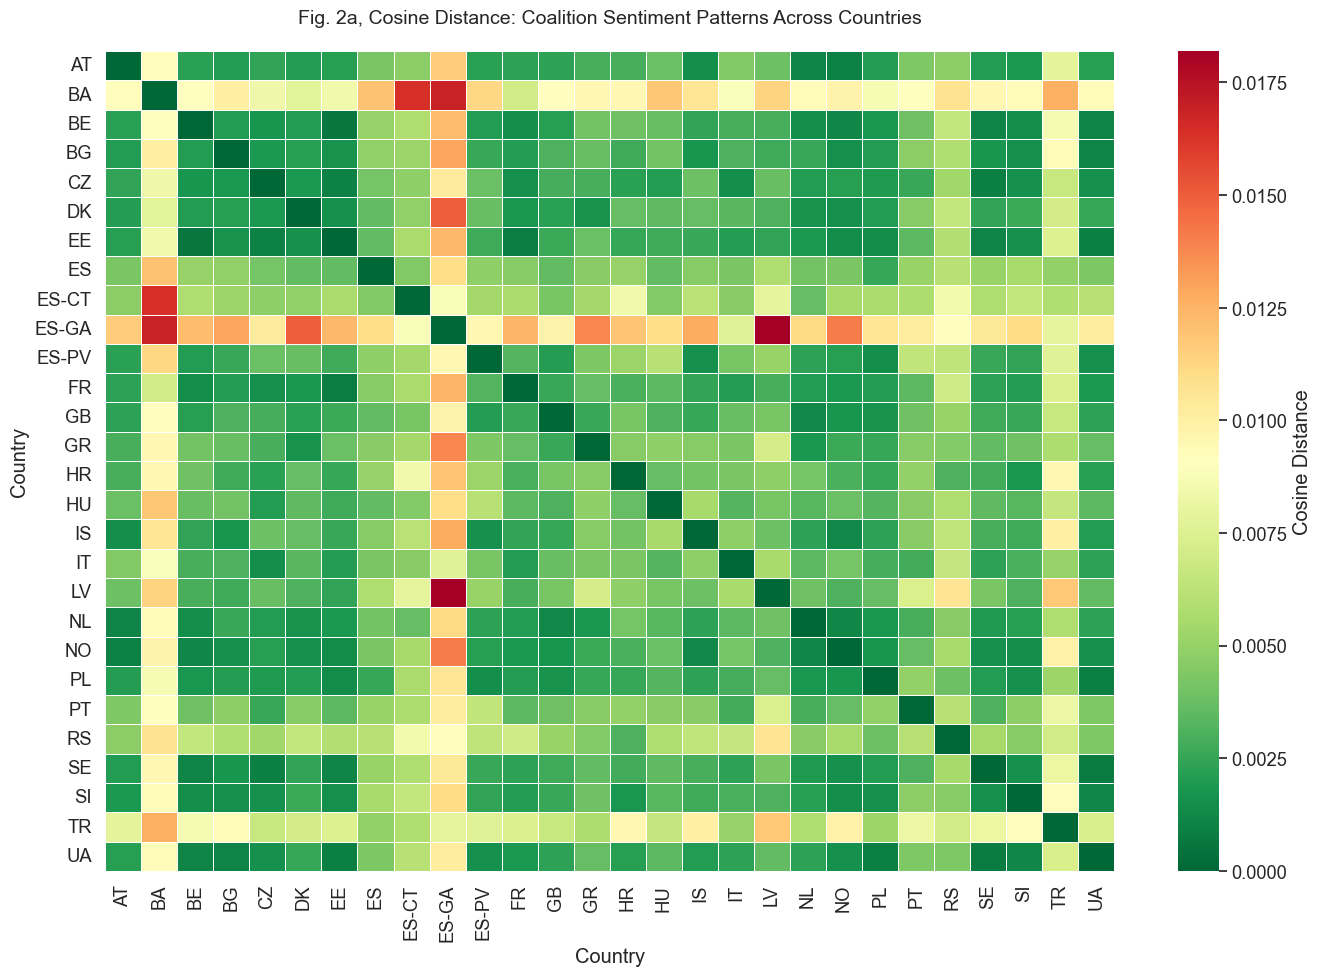

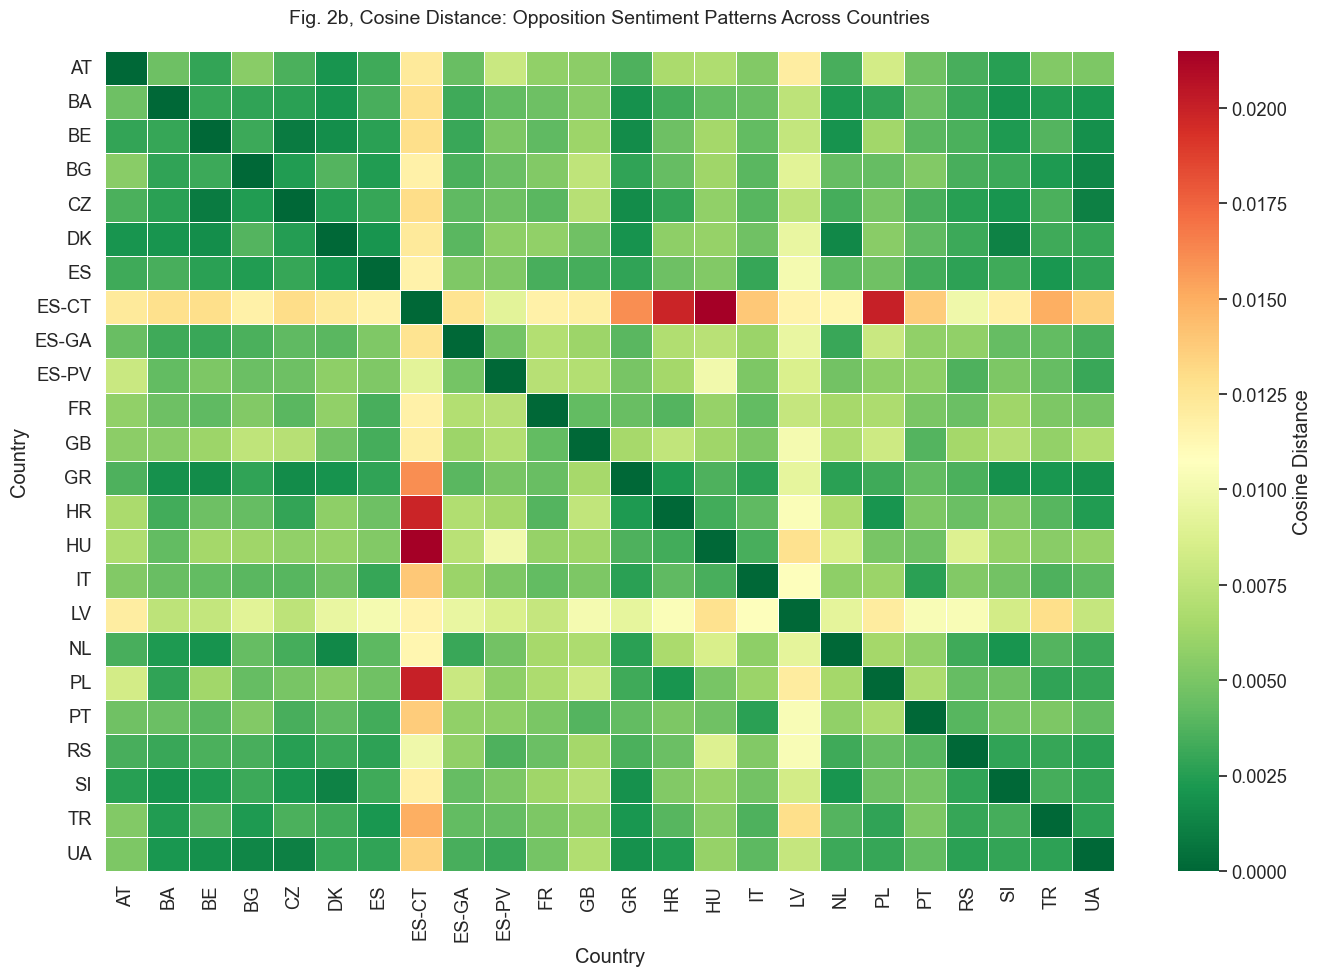

C:\Users\isabe\AppData\Local\Temp\ipykernel_14040\3853513990.py:57: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  coalition_linkage = sch.linkage(coalition_dist, method='ward')


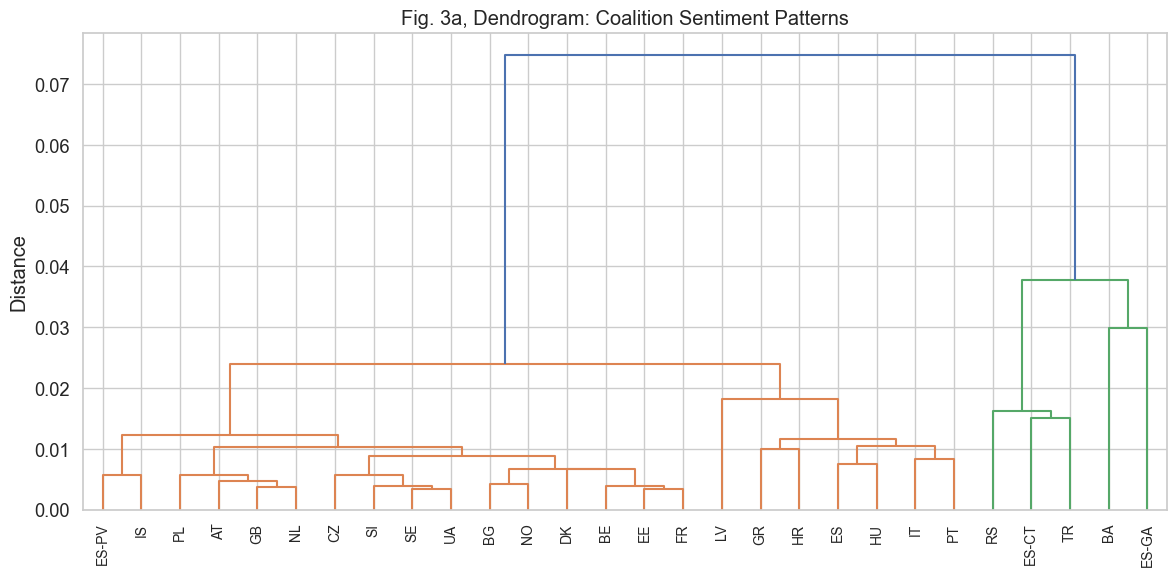

C:\Users\isabe\AppData\Local\Temp\ipykernel_14040\3853513990.py:66: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  opposition_linkage = sch.linkage(opposition_dist, method='ward')


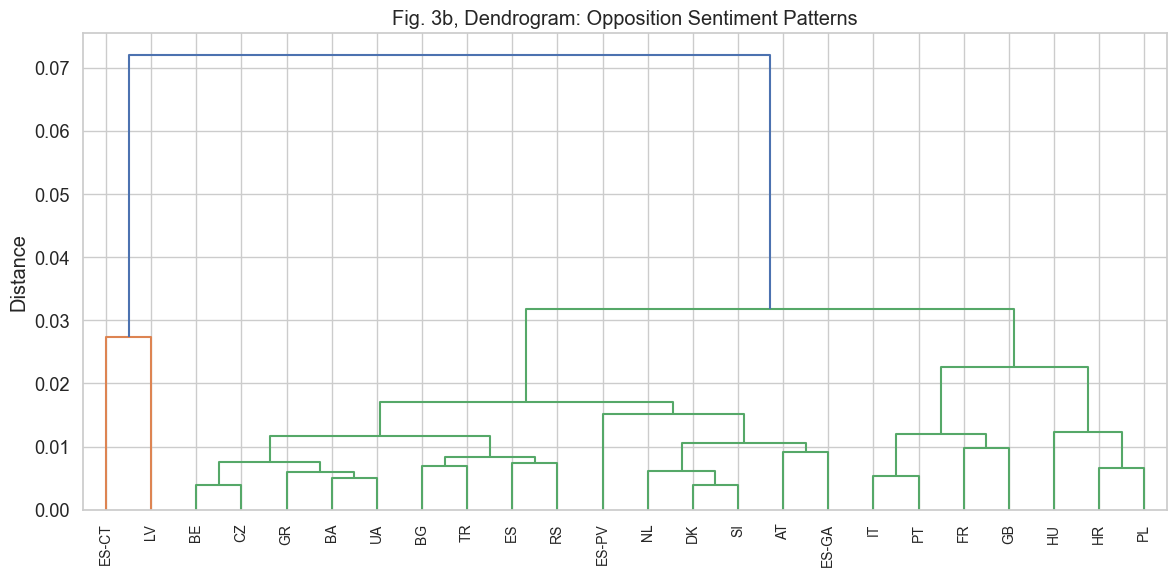

In [16]:
# ---- 1. Prepare data for cosine distance ----
# Use mean sentiment per country across CAP categories
# Separate for coalition and opposition
coalition_vectors = coalition_sentiment.fillna(0)  # fill missing CAPs with 0
opposition_vectors = opposition_sentiment.fillna(0)  # fill missing CAPs with 0

# ---- 2. Compute cosine distance matrices ----
coalition_dist = cosine_distances(coalition_vectors)
opposition_dist = cosine_distances(opposition_vectors)

# ---- 3. Convert to DataFrames for easier plotting ----
coalition_dist_df = pd.DataFrame(coalition_dist, index=coalition_vectors.index, columns=coalition_vectors.index)
opposition_dist_df = pd.DataFrame(opposition_dist, index=opposition_vectors.index, columns=opposition_vectors.index)

# ---- 4. Plot cosine distance heatmaps ----
# Coalition
plt.figure(figsize=(14, 10))
sns.heatmap(
    coalition_dist_df,
    annot=False,
    fmt=".2f",
    cmap="RdYlGn_r",         
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Cosine Distance'}
)
plt.title("Fig. 2a, Cosine Distance: Coalition Sentiment Patterns Across Countries", fontsize=14, pad=20)
plt.xlabel("Country")
plt.ylabel("Country")
plt.xticks(rotation=90, ha='center')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Opposition
plt.figure(figsize=(14, 10))
sns.heatmap(
    opposition_dist_df,
    annot=False,
    fmt=".2f",
    cmap="RdYlGn_r",
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Cosine Distance'}
)
plt.title("Fig. 2b, Cosine Distance: Opposition Sentiment Patterns Across Countries", fontsize=14, pad=20)
plt.xlabel("Country")
plt.ylabel("Country")
plt.xticks(rotation=90, ha='center')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ---- 5. Create dendrograms ----
# Coalition
plt.figure(figsize=(12, 6))
coalition_linkage = sch.linkage(coalition_dist, method='ward')
sch.dendrogram(coalition_linkage, labels=coalition_vectors.index, leaf_rotation=90)
plt.title("Fig. 3a, Dendrogram: Coalition Sentiment Patterns")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# Opposition
plt.figure(figsize=(12, 6))
opposition_linkage = sch.linkage(opposition_dist, method='ward')
sch.dendrogram(opposition_linkage, labels=opposition_vectors.index, leaf_rotation=90)
plt.title("Fig. 3b, Dendrogram: Opposition Sentiment Patterns")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


*The coalition cosine distance heatmap (Fig. 2a) shows that most countries are relatively dissimilar (reddish), but some paris stand out as very similar (very green), including **ES-GA, BA and TR**. Overall the pattern suggests that coalition sentiment patterns are **moderately consistent**, but with some countries exhibiting distinct behavior.*


*The coaltion dendrogram (Fig. 3a) confirms that most coalition sentiment patterns are **very similar** - the linkages are low and we can identify small clusters of similar coutnries, while **RS, ES-CT, TR, BA and ES-GA** stand out at the periphery indicating more distinct sentiment patterns.*

*The opposition cosine distance heatmap (Fig. 2b) shows the most similar (green) opposition across parliament include **ES-CT and LV**, as well as **HU, HR and PL**. Most other countries are relatively dissimilar (red), reflecting that opposition parties differ morei n how they frame policy debates.*

*The opposition dendrogram (Fig. 3b) also shows that sentiment patterns are largely similar overall. Certain countries form close pairs, e.g. **BE & CZ, BA & UA, DK & SI**, while **ES-CT and LV** remain separate clusters, highlighting a more divergent opposition sentiment behavior.*

Now that we have visualized the sentiment patterns across coalitions and oppositions across parliaments using heatmaps and dendrograms, we can already see clsuters of similar behaviors and a few outliers. To make these patterns more **explicit and quantitative**, we can identiy the **nearest neighbors** for each country, like we did in **Tutorial 3, section 4.3**, to see the parliaments whose sentiment patterns are most similar. This approach allows us to systematically pinpoint which parliaments are the closest in their framing of policy topics.


**3.2. Nearest neighbors**

In this section, we compute the **three nearest neighbors** for each country based on the cosine distances of mean sentiment across CAP categories. We do this separately for coalition and opposition parties, taking care to exclude countries with missing opposition data to avoid misleading results. 



In [ ]:
# ---- 1. Identify coalition nearest neighbors ----
nearest_neighbors_coalition = {}
for country in coalition_dist_df.index:
    distances = coalition_dist_df.loc[country]
    neighbors = distances[distances > 0].nsmallest(3).index.tolist()  # exclude self
    nearest_neighbors_coalition[country] = neighbors

nearest_neighbors_coalition_df = pd.DataFrame.from_dict(
    nearest_neighbors_coalition, orient='index', columns=['NN1', 'NN2', 'NN3']
)
print("Coalition: 3 Nearest Neighbors per Country")
print(nearest_neighbors_coalition_df)

# ---- 2. Identify opposition nearest neighbors (exclude missing opposition countries) ----
opposition_vectors_clean = opposition_sentiment.drop(index=missing_opposition)
opposition_dist_clean = cosine_distances(opposition_vectors_clean)
opposition_dist_df_clean = pd.DataFrame(
    opposition_dist_clean,
    index=opposition_vectors_clean.index,
    columns=opposition_vectors_clean.index
)

nearest_neighbors_opposition = {}
for country in opposition_dist_df_clean.index:
    distances = opposition_dist_df_clean.loc[country]
    neighbors = distances[distances > 0].nsmallest(3).index.tolist()  # exclude self
    nearest_neighbors_opposition[country] = neighbors

nearest_neighbors_opposition_df = pd.DataFrame.from_dict(
    nearest_neighbors_opposition, orient='index', columns=['NN1', 'NN2', 'NN3']
)
print("\nOpposition: 3 Nearest Neighbors per Country")
print(nearest_neighbors_opposition_df)

Coalition: 3 Nearest Neighbors per Country
      NN1 NN2    NN3
AT     NO  NL     IS
BA     FR  DK     CZ
BE     EE  SE     UA
BG     UA  SI     NO
CZ     SE  EE     IT
DK     NO  EE     NL
EE     BE  FR     UA
ES     PL  HU     GB
ES-CT  NL  GB     ES
ES-GA  IT  TR  ES-CT
ES-PV  PL  UA     IS
FR     EE  BE     CZ
GB     NL  PL     NO
GR     DK  NL     PL
HR     SI  UA     CZ
HU     CZ  EE     GB
IS     NO  AT  ES-PV
IT     CZ  EE     FR
LV     EE  BG     FR
NL     AT  NO     GB
NO     AT  NL     BE
PL     UA  EE  ES-PV
PT     CZ  IT     NL
RS     HR  PL     UA
SE     UA  CZ     BE
SI     UA  BE     NO
TR     ES  IT     PL
UA     SE  PL     EE

Opposition: 3 Nearest Neighbors per Country
         NN1 NN2 NN3
AT        DK  SI  BE
BA        GR  SI  DK
BE        CZ  GR  DK
BG        UA  TR  ES
CZ        BE  UA  GR
DK        SI  NL  BE
ES        DK  TR  BG
ES-CT  ES-PV  RS  NL
ES-GA     BE  NL  BA
ES-PV     UA  RS  BA
FR        ES  HR  CZ
GB        ES  PT  FR
GR        BE  CZ  SI
HR       

*The nearest-neighbor analysis reveals some patterns of similarity across countries. For the **coalition**, some countries cluster with geographically partners, such as **DK & NO** or **FR & BE**. In the **opposition**, countries like **AT, DK and SI** repeatedly appear as neighbors, indicating broadly similar opposition sentiment across these parliaments, whereas outliers like **ES-CT, LV and TR** form more isolated clusters. Overall, the results confirm that whole many countries share comparable sentiment patterns within coalition and opposition, certain countries stand out as distinctive. These patterns can guide a potentially more focused comparison and serve as a foundation for research on typical and excecptional parliamentary behavior.*

Having examined sentiment patterns and cross-country similarities, we now shift our focus from **sentimental tone** to a **topic share analysis**. While the previous section looked at the tone of parliamentary speeches, the next step is to explore the **distribution of topics across CAP categories** and how this varies between coalition and opposition parties.

**4. Topic Share across CAP Categories (filtered by party status)**

In this section, we analyze the **topic share across CAP categories**, based on word counts in speeches. By comparing coalition and opposition parties, we can identify which policy areas each party type emphasized most, detect patterns of attention across parliaments, and assess whether differences in sentiment are accompanied by differences in topic focus. This analysis provides a complementary view to the sentiment study and helps build a fuller picture of parliamentary discourse. 

C:\Users\isabe\AppData\Local\Temp\ipykernel_14040\1318470750.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['country', 'CAP_category'])['word_count']
C:\Users\isabe\AppData\Local\Temp\ipykernel_14040\1318470750.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['country', 'CAP_category'])['word_count']
C:\Users\isabe\AppData\Local\Temp\ipykernel_14040\1318470750.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

TOPIC SHARE SUMMARY ACROSS ALL COUNTRIES

Overall (All Parties) Topic Share (proportion of words):
Mean: 0.048
Std: 0.039
Min: 0.000
Max: 0.308

Coalition Topic Share (proportion of words):
Mean: 0.048
Std: 0.040
Min: 0.000
Max: 0.321

Opposition Topic Share (proportion of words):
Mean: 0.041
Std: 0.042
Min: 0.000
Max: 0.307

DETAILED TOPIC SHARE BY COUNTRY
   country  overall_mean  coalition_mean  opposition_mean
0       AT         0.048           0.048            0.048
1       BA         0.048           0.048            0.048
2       BE         0.048           0.048            0.048
3       BG         0.048           0.048            0.048
4       CZ         0.048           0.048            0.048
5       DK         0.048           0.048            0.048
6       EE         0.048           0.048            0.000
7       ES         0.048           0.048            0.048
8    ES-CT         0.048           0.048            0.048
9    ES-GA         0.048           0.048            0.048
10

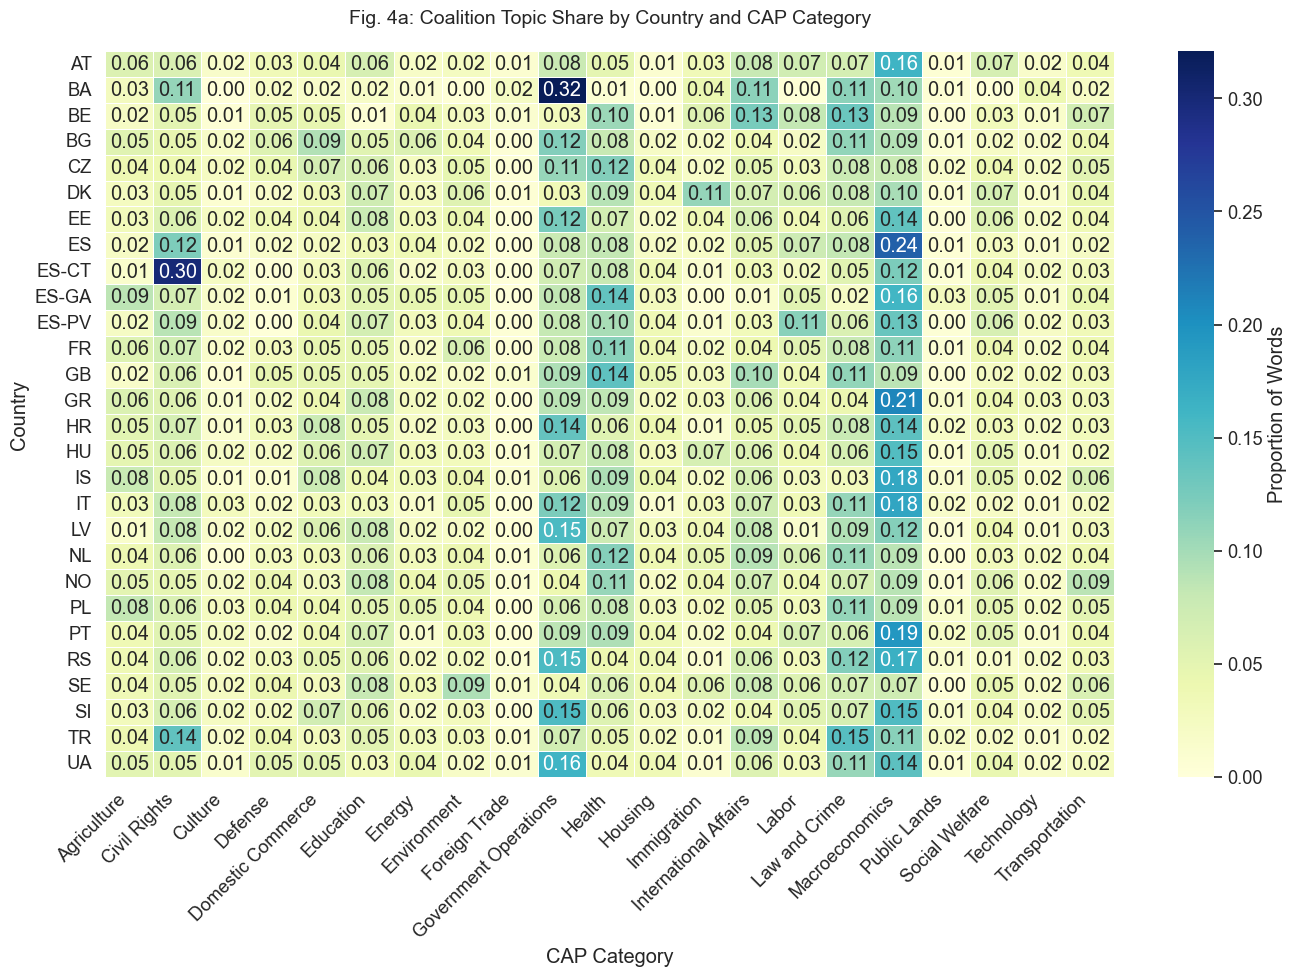

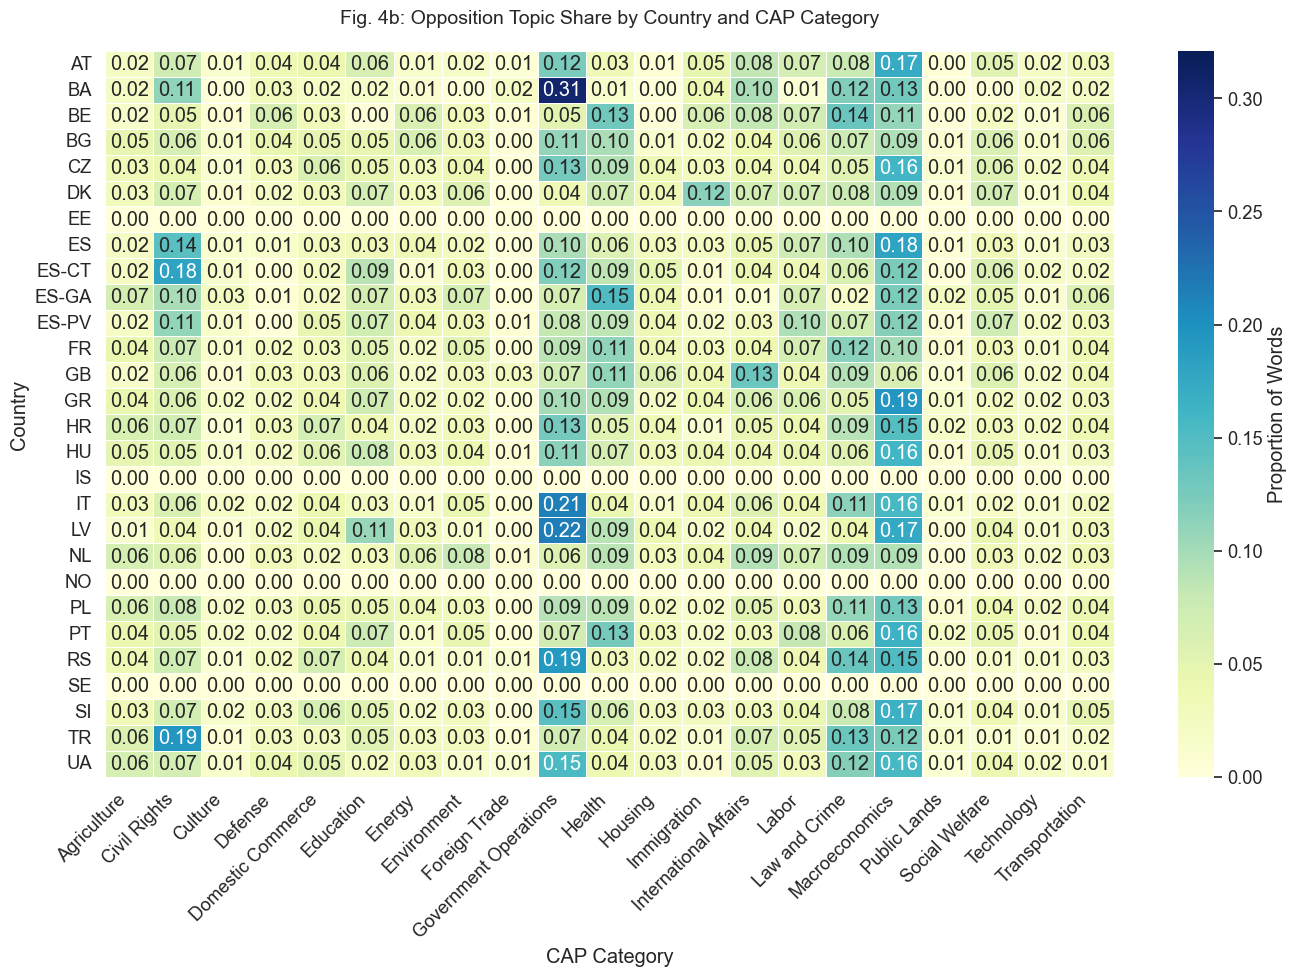

C:\Users\isabe\AppData\Local\Temp\ipykernel_14040\1318470750.py:127: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  coalition_linkage = sch.linkage(coalition_dist, method='ward')


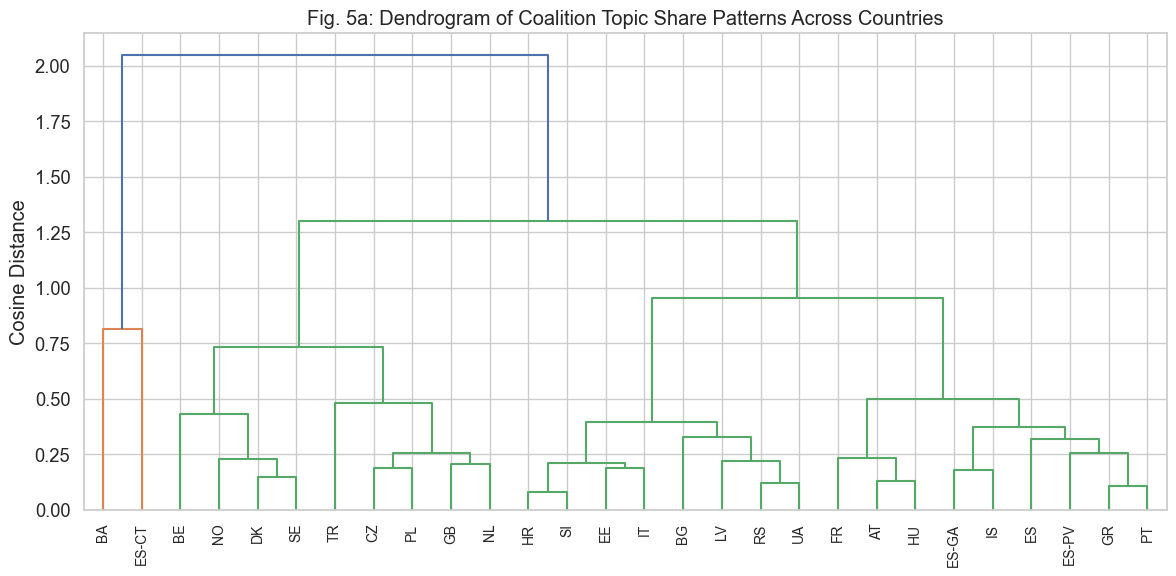

C:\Users\isabe\AppData\Local\Temp\ipykernel_14040\1318470750.py:150: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  opposition_linkage = sch.linkage(opposition_dist_clean, method='ward')


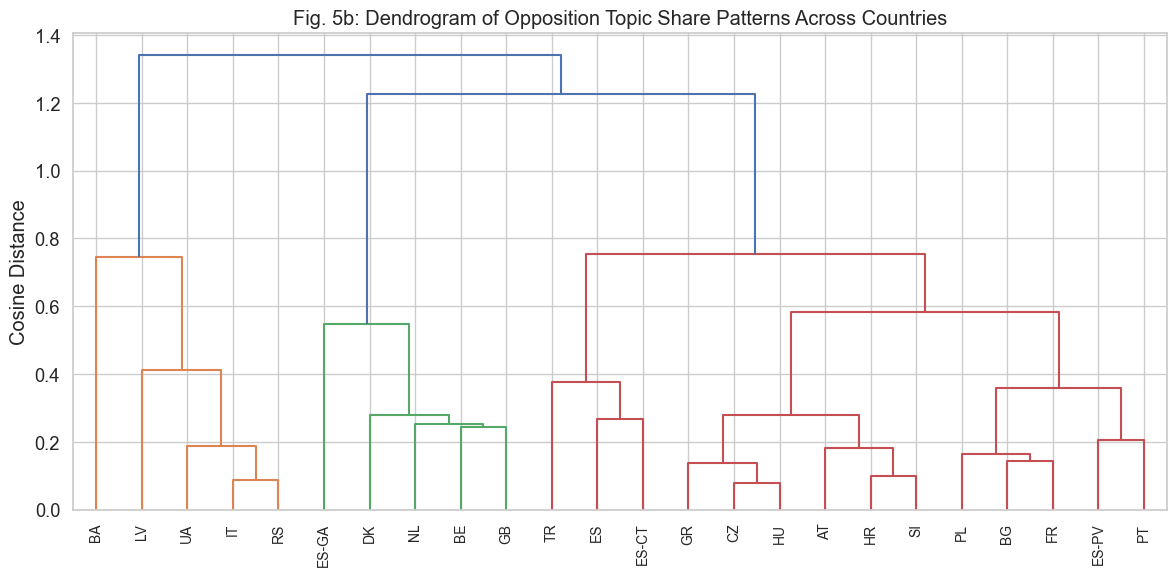

In [7]:
# ---- 1. Compute topic share (proportion of words) by country and CAP category ----

# Overall (both parties combined)
overall_topic = (
    filtered_all
    .groupby(['country', 'CAP_category'])['word_count']
    .sum()
    .unstack()  # Do NOT fill with 0 here yet
)

# Compute proportions per country
overall_topic = overall_topic.div(overall_topic.sum(axis=1), axis=0)

# Coalition
coalition_topic = (
    filtered_all[filtered_all['party_status'] == 'Coalition']
    .groupby(['country', 'CAP_category'])['word_count']
    .sum()
    .unstack()
)
coalition_topic = coalition_topic.div(coalition_topic.sum(axis=1), axis=0)

# Opposition
opposition_topic = (
    filtered_all[filtered_all['party_status'] == 'Opposition']
    .groupby(['country', 'CAP_category'])['word_count']
    .sum()
    .unstack()
)
opposition_topic = opposition_topic.div(opposition_topic.sum(axis=1), axis=0)

# ---- 1.1 Reindex coalition and opposition to include all countries ----
all_countries = overall_topic.index
coalition_topic = coalition_topic.reindex(all_countries).fillna(0).astype(float)
opposition_topic = opposition_topic.reindex(all_countries).fillna(0).astype(float)

# ---- 2. Print summary statistics ----
def print_stats(df, name):
    values = df.values
    print(f"\n{name} Topic Share (proportion of words):")
    print(f"Mean: {pd.Series(values.flatten()).mean():.3f}")
    print(f"Std: {pd.Series(values.flatten()).std():.3f}")
    print(f"Min: {pd.Series(values.flatten()).min():.3f}")
    print(f"Max: {pd.Series(values.flatten()).max():.3f}")

print("TOPIC SHARE SUMMARY ACROSS ALL COUNTRIES")
print("=" * 50)
print_stats(overall_topic, "Overall (All Parties)")
print_stats(coalition_topic, "Coalition")
print_stats(opposition_topic, "Opposition")

# ---- 3. Detailed topic share by country ----
country_topic_stats = []
for country in overall_topic.index:
    overall_mean = overall_topic.loc[country].mean()
    coalition_mean = coalition_topic.loc[country].mean()
    opposition_mean = opposition_topic.loc[country].mean()
    country_topic_stats.append({
        'country': country,
        'overall_mean': overall_mean,
        'coalition_mean': coalition_mean,
        'opposition_mean': opposition_mean
    })

country_topic_stats_df = pd.DataFrame(country_topic_stats)
print("\n" + "="*50)
print("DETAILED TOPIC SHARE BY COUNTRY")
print("="*50)
print(country_topic_stats_df.round(3))

# ---- 3.1 Save as TSV ----
output_path = "detailed_topic_share_by_country.tsv"
country_topic_stats_df.to_csv(output_path, sep='\t', index=False)
print(f"\nSaved detailed topic share table to {output_path}")

# ---- 4. Determine shared color scale ----
all_values = pd.concat([coalition_topic.stack(), opposition_topic.stack()]).dropna()
vmin = all_values.min()
vmax = all_values.max()

# ---- 4.1 Heatmap for Coalition topic share ----
plt.figure(figsize=(14, 10))
sns.heatmap(
    coalition_topic,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    vmin=vmin,
    vmax=vmax,
    cbar_kws={'label': 'Proportion of Words'},
    linewidths=0.5,
    linecolor='white'
)
plt.title("Fig. 4a: Coalition Topic Share by Country and CAP Category", fontsize=14, pad=20)
plt.xlabel("CAP Category")
plt.ylabel("Country")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ---- 4.2 Heatmap for Opposition topic share ----
plt.figure(figsize=(14, 10))
sns.heatmap(
    opposition_topic,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    vmin=vmin,
    vmax=vmax,
    cbar_kws={'label': 'Proportion of Words'},
    linewidths=0.5,
    linecolor='white'
)
plt.title("Fig. 4b: Opposition Topic Share by Country and CAP Category", fontsize=14, pad=20)
plt.xlabel("CAP Category")
plt.ylabel("Country")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ---- 5. Compute cosine distances for dendrograms ----
coalition_dist = cosine_distances(coalition_topic)
opposition_dist = cosine_distances(opposition_topic)

# ---- 5.1 Dendrogram for Coalition Topic Share ----
plt.figure(figsize=(12, 6))
coalition_linkage = sch.linkage(coalition_dist, method='ward')
sch.dendrogram(
    coalition_linkage,
    labels=coalition_topic.index,
    leaf_rotation=90
)
plt.title("Fig. 5a: Dendrogram of Coalition Topic Share Patterns Across Countries")
plt.ylabel("Cosine Distance")
plt.tight_layout()
plt.show()

# ---- 5.2 Dendrogram for Opposition Topic Share ----
# Identify countries with no annotated opposition data
missing_opposition = opposition_topic[(opposition_topic == 0).all(axis=1)].index.tolist()

# Drop missing opposition countries
opposition_topic_clean = opposition_topic.drop(index=missing_opposition)

# Compute cosine distance matrix
opposition_dist_clean = cosine_distances(opposition_topic_clean)

# Generate dendrogram
plt.figure(figsize=(12, 6))
opposition_linkage = sch.linkage(opposition_dist_clean, method='ward')
sch.dendrogram(
    opposition_linkage,
    labels=opposition_topic_clean.index,
    leaf_rotation=90
)
plt.title("Fig. 5b: Dendrogram of Opposition Topic Share Patterns Across Countries")
plt.ylabel("Cosine Distance")
plt.tight_layout()
plt.show()


*Looking at the statistics summary, we see that the mean proportion of words per CAP category is quite low (mean: 0.048) with some variation (std: 0.039). Coalition parties show a very similar pattern overall (mean: 0.048, std: 0.040), while opposition parties have a lower average share (mean: 0.041, std: 0.042).*

*The coalition heatmap (Fig. 4a) highlights that topics like **Macroeconomics, Government Operations, Health and Law and Crime** dominate in most countries which aligns with our findings from previous tutorials. A few outliers stand out, such as **ES-CT for Civil Rights (0.30)** and **BA for Government Operations (0.32)**. The opposition heatmap (Fig. 4b) shows a very similar distribution across CAP categories, which indicates that both coalition and opposition tend to focus on largely the same policy areas.*

*To see **how similar countries are to each other** regarding the topic share across topics and party stauts, we look at the dendrograms. In the coalition dendrogram (Fig. 5a), we observe **many small clusters of closely aligned parliaments**, such as **Denmark (DK) & Sweden (SE), Serbia (RS) & Ukraine (UA) and Greece (GR) & Portugal (PT)**. At the same time, some countries stand apart, like **Bosnia & Herzegovina (BA) and ES-CT**, indicating that their topic focus is less similar to the rest of the coalition parties.*

**4.2. Nearest neighbors**

To make these relationships, observed in the heatmaps and dendrograms from Section 4.1, more precise and quantitative, we can identify the **three nearest neighbors for each country** using cosine distances. 

In [46]:
# ---- 1. Compute cosine distances ----
coalition_dist_matrix = cosine_distances(coalition_topic.fillna(0))
opposition_dist_matrix = cosine_distances(opposition_topic_clean.fillna(0))  # exclude missing countries

# ---- 2. Convert to DataFrame ----
coalition_dist_df = pd.DataFrame(coalition_dist_matrix, index=coalition_topic.index, columns=coalition_topic.index)
opposition_dist_df = pd.DataFrame(opposition_dist_matrix, index=opposition_topic_clean.index, columns=opposition_topic_clean.index)

# ---- 3. Find 3 nearest neighbors for each country ----
def get_nearest_neighbors(dist_df, n=3):
    neighbors = {}
    for country in dist_df.index:
        # sort distances ascending (smaller = more similar), exclude self (distance=0)
        nearest = dist_df.loc[country].drop(country).sort_values().index[:n].tolist()
        neighbors[country] = nearest
    return pd.DataFrame(neighbors).T.rename(columns={0:'NN1', 1:'NN2', 2:'NN3'})

coalition_nn = get_nearest_neighbors(coalition_dist_df, n=3)
opposition_nn = get_nearest_neighbors(opposition_dist_df, n=3)

# ---- 4. Display nearest neighbors ----
print("Coalition: 3 Nearest Neighbors per Country")
print(coalition_nn)
print("\nOpposition: 3 Nearest Neighbors per Country")
print(opposition_nn)


Coalition: 3 Nearest Neighbors per Country
      NN1 NN2    NN3
AT     HU  GR     EE
BA     UA  LV     RS
BE     NL  GB     DK
BG     CZ  HR     PL
CZ     FR  BG     GB
DK     NL  SE     HU
EE     SI  LV     HU
ES     PT  IT     GR
ES-CT  TR  ES  ES-PV
ES-GA  PT  IS     FR
ES-PV  PT  FR     AT
FR     CZ  PL     NL
GB     NL  CZ     FR
GR     PT  HU     AT
HR     SI  RS     UA
HU     AT  GR     EE
IS     GR  HU     PT
IT     RS  HR     EE
LV     EE  RS     SI
NL     GB  FR     NO
NO     SE  PL     NL
PL     FR  NO     BG
PT     GR  AT     HU
RS     UA  HR     SI
SE     NO  DK     NL
SI     HR  EE     RS
TR     IT  PL     RS
UA     RS  HR     SI

Opposition: 3 Nearest Neighbors per Country
         NN1    NN2 NN3
AT        SI     HU  GR
BA        IT     RS  UA
BE        NL     FR  PL
BG        PL     FR  CZ
CZ        HU     SI  HR
DK        NL     FR  GB
EE        AT     BA  BE
ES        TR  ES-PV  AT
ES-CT  ES-PV     ES  TR
ES-GA     PT  ES-PV  FR
ES-PV     FR     ES  PT
FR        PL   

*The nearest neighbors analysis shows that among the coalition countries , we can observe regionally clustering as well: **AT and HU** form a close group, as well as **HR & SI** and **BG & CZ**. Some countries, such as **ES-CT and TR** are more distinct which aligns with our previous observations.*

*For the opposition, a similar pattern can be observed, though there is generally more variation between countries, which is likely due to differences in opposition size or focus.*

*These nearest neighbors complement the dendrograms, qunatifying similarities that were visually apparent in the clusters. This offers a concrete basis for further parliamentary analyses.*


**5. Relative Word Count Differences by Party Status and CAP Category**

In this section, we compare how much coalition and opposition parties speak across CAP categories. Using the relative difference metric (Coalition - Opposition / (Coalition + Opposition)), we can see which parliaments or CAP categories are dominated by coalition speeches, which by opposition and which are more balanced. The heatmap provides a quick visual overview with red indicating a stronger presence of coalition speeches and blue indicating opposition dominance and white indicating roughly equal participation. This will help contextualize the results from sentiment (section 3) and topic share (section 4) analyses by highlighting the actual volume of debate contributions per coalition and opposition. 

Countries with no opposition data: ['EE', 'IS', 'NO', 'SE']


C:\Users\isabe\AppData\Local\Temp\ipykernel_14040\2104727476.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = filtered_all_clean.pivot_table(


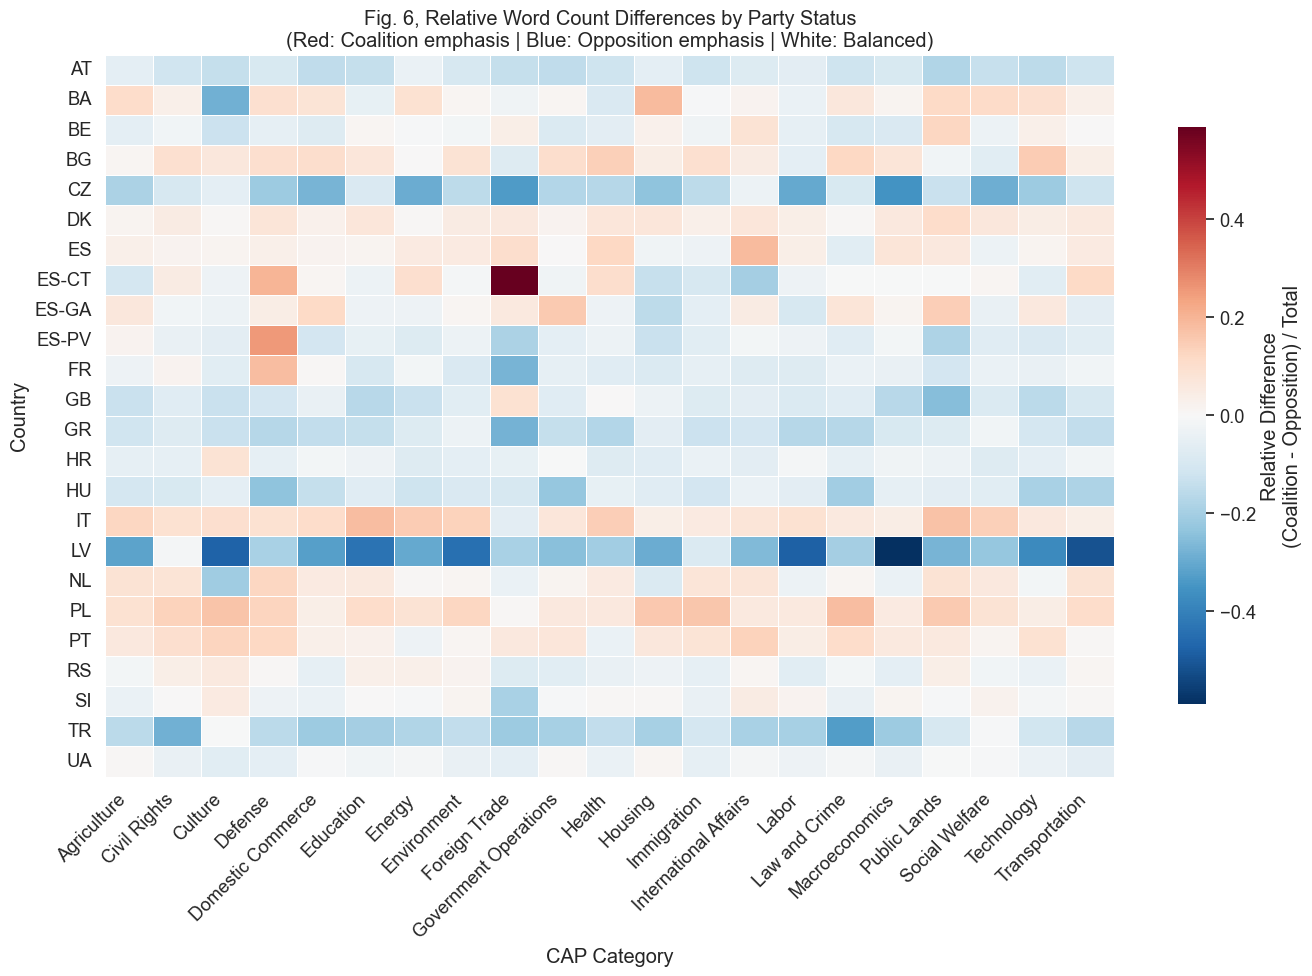

In [11]:
# ---- 0. Identify countries with missing opposition data ----
missing_opposition = opposition_topic[(opposition_topic == 0).all(axis=1)].index.tolist()
print("Countries with no opposition data:", missing_opposition)

# ---- 1. Filter out missing opposition countries from main DataFrame ----
filtered_all_clean = filtered_all[~filtered_all['country'].isin(missing_opposition)]

# ---- 2. Pivot table: country x CAP_category, columns = party_status ----
pivot_df = filtered_all_clean.pivot_table(
    index=['country', 'CAP_category'],
    columns='party_status',
    values='word_count',
    fill_value=0
).reset_index()

# ---- 3. Calculate relative difference (Coalition - Opposition) / Total ----
if 'Coalition' in pivot_df.columns and 'Opposition' in pivot_df.columns:
    total_words = pivot_df['Coalition'] + pivot_df['Opposition']
    pivot_df['rel_diff'] = (pivot_df['Coalition'] - pivot_df['Opposition']) / (total_words + 1e-10)

# ---- 4. Pivot for heatmap ----
rel_pivot = pivot_df.pivot(index='country', columns='CAP_category', values='rel_diff')
rel_pivot = rel_pivot.astype(float)

# ---- 5. Plot heatmap ----
plt.figure(figsize=(14, 10))
sns.heatmap(
    rel_pivot,
    cmap='RdBu_r',
    center=0,
    annot=False,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Relative Difference\n(Coalition - Opposition) / Total', 'shrink': 0.8}
)
plt.title(
    'Fig. 6, Relative Word Count Differences by Party Status\n'
    '(Red: Coalition emphasis | Blue: Opposition emphasis | White: Balanced)'
)
plt.xlabel('CAP Category')
plt.ylabel('Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


*Figure 6 shows that coalition parties speak more in **Poland (PL), Portugal (PT), Italy (IT) and the Netherlands (NL)**, while opposition parties dominate in **Austria (AT), Czech Republic (CZ), Latvia (LV) and Turkey (TR)**. Differences across CAP topics are less pronounced. This indicates that volume disparities are mostly country-specific rather than topic-specific.*

**6. Conclusion**

This notebook demonstrates how parliamentary discourse can be systematically analyzed by party stauts across multiple parliaments. By combining **sentiment analysis, topic share, cosine distances, dendrograms, nearest neighbors and relative word counts**, we identified both general patterns and country-specific behaviors. Coalition parties generally exhibit a more positive tone and speak more in certain countries, while opposition parties tend to be more critical and dominate speech volume elsewhere. Topic distributions are largely similar between coalition and opposition, but small differences emerge in outlier countries. Overall, these method provide a framework that can be useful for comparing parliamentary behavior and highlighting **shared patterns** and **distinctive cases** across European parliaments